# Skill Clustering
In this notebook we will ....

As a very first step we get our example jira stories, extract skill entities and create a dictionary of the skill in order to train the LDA model afterwards.


In [1]:
import numpy as np
from sklearn.cluster import KMeans
import spacy
import nltk
import re
import pandas as pd
import os


# 1. Get the data

folder_path = 'C:/Users/SEPA/lanchain_ir2/Tech_data/ChatGPT_jira_stories'  # Replace with the path to your folder
file_list = []

# Iterate over each file in the folder and append its content
for filename in os.listdir(folder_path):
    # print(filename)
    #if filename.endswith('.txt'):
    if filename == 'cloud.txt' or filename == 'DataScience.txt':
        # print(filename)
        file_path = os.path.join(folder_path, filename)

        # Open the file and read its contents
        with open(file_path, 'r') as file:
            content = file.read()
            file_list.append(content)

all_files = []
for file in file_list:
    sample_list = file.split('Title')
    all_files += [sample.replace("\nDescription: ", ". ") for sample in sample_list]


# 2. load our custom NER model and extract the skills from the jira stories
nlp_ner = spacy.load("C:/Users/SEPA/lanchain_ir2/model-best")

extracted_entities_all = []
for sample in all_files:
    doc = nlp_ner(sample)
    extracted_skills = []
    for ent in doc.ents:
        extracted_skills.append(ent.text)
    if extracted_skills:
        # Code to be executed if the list is not empty
        extracted_skills = [element.replace(" ", "_").replace("-", "_") for element in extracted_skills] # build bigrams, trigramms automatically
        extracted_entities_all.append(' '.join(extracted_skills))
    else:
        continue

df = pd.DataFrame(extracted_entities_all)
df = df.rename(columns={0: 'skill_description'})
df = df[df['skill_description'] != '']


# 3. Create dictionary to train the LDA model
from gensim import corpora
series = df['skill_description']
split_series = series.str.split(' ')
dictionary = corpora.Dictionary(split_series)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in split_series]

Now, we will train the LDA model using the dictionary with our created skills and plot the most frequent terms per topic. We choosed to search for two topics as we only included jira stories related to cloud and data-science. 

In [2]:
import gensim
import matplotlib.pyplot as plt

Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=2, id2word = dictionary, passes=100,\
               iterations=300, chunksize = 50, eval_every = None, random_state=0)
import pyLDAvis.gensim
# visualization with pyLDAvis
topic_data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)

# Assign skill cluster to applicant
As we can see from the plot the LDA model has successfully detected the two major skill clusters. While skillcluster cloud consists terms such as AWS, cloud_engineer or Azure, skillcluster Data Science consists of terms such as Data Scientist, Python, scikit_learn.

Let's check weather we our model is able to assign skill clusters to an employee has skill in AWS EC2, Deployments and DevOps.

In [4]:
print(extracted_entities_all[0])# example skills

AWS_EC2 Deployment DevOps AWS_EC2 resource


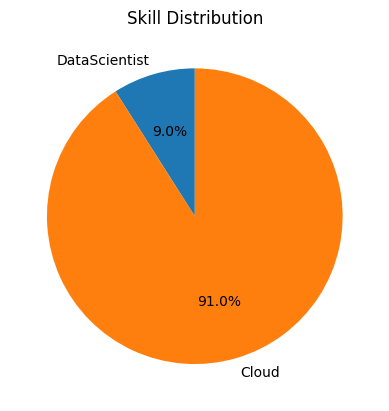

In [5]:
# Create empty data frame with column names for topics
topic_columns = [f'Topic {i}' for i in range(ldamodel.num_topics)]
df = pd.DataFrame(columns=topic_columns)

# Iterate over documents and add topic distribution as rows
i=0
for doc in doc_term_matrix:
    topic_dist = ldamodel.get_document_topics(doc, minimum_probability=0)
    topic_probabilities = [prob for _, prob in topic_dist]
    df.loc[len(df)] = topic_probabilities
topics_all = df

# Data for the pie chart
labels = ['DataScientist', 'Cloud']
sizes = topics_all.iloc[0] # Represents the percentage of each slice
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Skill Distribution')
plt.show()

The successful assignment of a higher percentage to the skill cluster "cloud" is evident in the LDA model's results.

# Skillclustering

Now, we will utilize the feature matrix derived from our LDA topic modeling algorithm to construct our clustering. We will first
increase the number of topics to 5, in oder to have a more granular features matrix available for the clustering. 
This feature matrix effectively captures the co-occurrence of words and the document's contribution to each topic. We then will visualize the results via a dendogramm which can be seen as a competence tree. Competence tree helps to explore specific competence areas in an intuitive way and to understand trends and connections within the competence tree.
For the purpose of clarity we truncate the dendogramm to eight final clusters.
As a next step we could also get the most frequent words per leaf or cluster to do further analysis by which terms the clusters are defined.

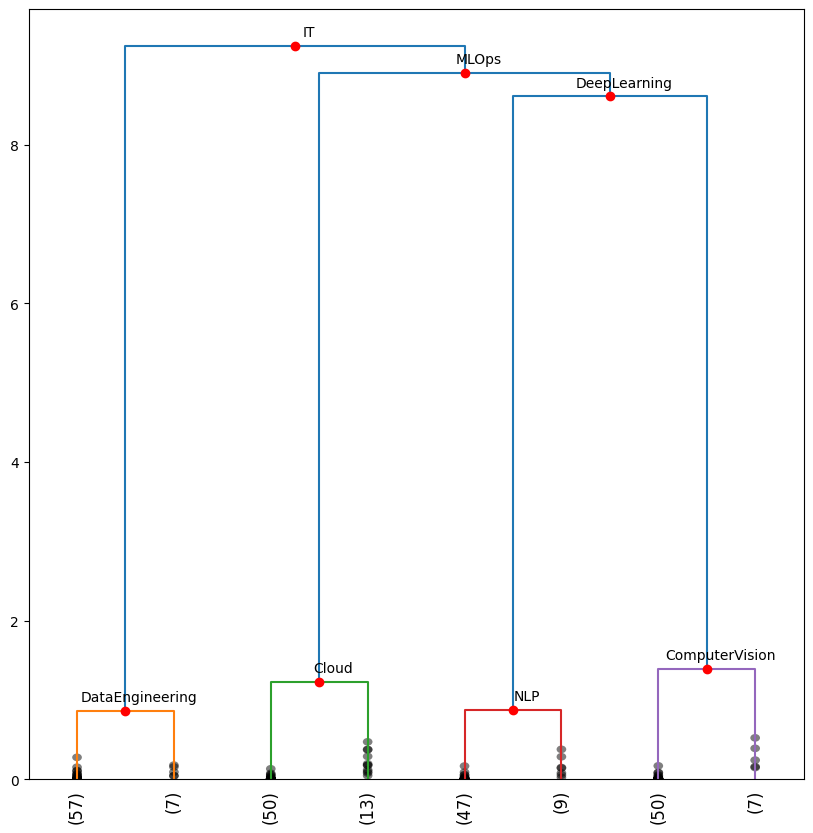

In [7]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=100,\
               iterations=300, chunksize = 50, eval_every = None, random_state=0)
topic_columns = [f'Topic {i}' for i in range(ldamodel.num_topics)]
df = pd.DataFrame(columns=topic_columns)
i=0
for doc in doc_term_matrix:
    topic_dist = ldamodel.get_document_topics(doc, minimum_probability=0)
    topic_probabilities = [prob for _, prob in topic_dist]
    df.loc[len(df)] = topic_probabilities
topics_all = df


from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

labels = ['DataEngineering', 'Cloud', 'NLP','ComputerVision','DeepLearning','MLOps','IT']
def augmented_dendrogram(*args, **kwargs):
    ddata = dendrogram(*args, **kwargs)
    if not kwargs.get('no_plot', False):
        for ind,(i, d) in enumerate(zip(ddata['icoord'], ddata['dcoord'])):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            plt.plot(x, y, 'ro')
            plt.annotate(labels[ind], (x, y), xytext=(10,15),
                         textcoords='offset points',
                         va='top', ha='center')
    return ddata



Z2 = linkage(topics_all, 'ward')
plt.figure(figsize=(10,10))
augmented_dendrogram(
    Z2,
    truncate_mode='lastp',
    p=8,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.show()